# Exploratory Data Analysis
___

Conducting an exploratory data analysis (EDA) of the dataset.

Key activities include:  
- Importing and preparing the data  
- Analyzing missing values and data distributions  
- Investigating the relationship between fraudulent and non-fraudulent transactions  
- Visualizing feature distributions and correlations  
- Assessing feature importance using logistic regression and ROC curves  
- Preparing data splits for model evaluation

## Load libraries

In [1]:
import sys
sys.path.append('../')

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression

from utils.read_data import read_data

In [2]:
SEED: int = 8

## Reading data

In [3]:
DATASET_PATH ="../dataset/"

In [4]:
df = read_data(DATASET_PATH)
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V1      284807 non-null  float64
 1   V2      284807 non-null  float64
 2   V3      284807 non-null  float64
 3   V4      284807 non-null  float64
 4   V5      284807 non-null  float64
 5   V6      284807 non-null  float64
 6   V7      284807 non-null  float64
 7   V8      284807 non-null  float64
 8   V9      284807 non-null  float64
 9   V10     284807 non-null  float64
 10  V11     284807 non-null  float64
 11  V12     284807 non-null  float64
 12  V13     284807 non-null  float64
 13  V14     284807 non-null  float64
 14  V15     284807 non-null  float64
 15  V16     284807 non-null  float64
 16  V17     284807 non-null  float64
 17  V18     284807 non-null  float64
 18  V19     284807 non-null  float64
 19  V20     284807 non-null  float64
 20  V21     284807 non-null  float64
 21  V22     28

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
V1,284807.0,1.168375e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,3.416908e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-1.379537e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.074095e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,9.604066e-16,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,1.487313e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-5.556467e-16,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,1.213481e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-2.406331e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995
V10,284807.0,2.239053e-15,1.088850,-24.588262,-0.535426,-0.092917,0.453923,23.745136


In [7]:
# Transform column names to lowercase
df.columns = df.columns.str.lower()
df.columns

Index(['v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10', 'v11',
       'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v20', 'v21',
       'v22', 'v23', 'v24', 'v25', 'v26', 'v27', 'v28', 'amount', 'class'],
      dtype='object')

In [8]:
df.duplicated().sum()

np.int64(9144)

In [9]:
df['class'].value_counts()

class
0    284315
1       492
Name: count, dtype: int64

## Exploratory Data Analysis

### Missing values

In [10]:
df.isnull().any()

v1        False
v2        False
v3        False
v4        False
v5        False
v6        False
v7        False
v8        False
v9        False
v10       False
v11       False
v12       False
v13       False
v14       False
v15       False
v16       False
v17       False
v18       False
v19       False
v20       False
v21       False
v22       False
v23       False
v24       False
v25       False
v26       False
v27       False
v28       False
amount    False
class     False
dtype: bool

### Relationship between fraudulent and no fraudulent transactions

In [11]:
df["class"].value_counts(normalize=True)*100

class
0    99.827251
1     0.172749
Name: proportion, dtype: float64

### Distribuition by column

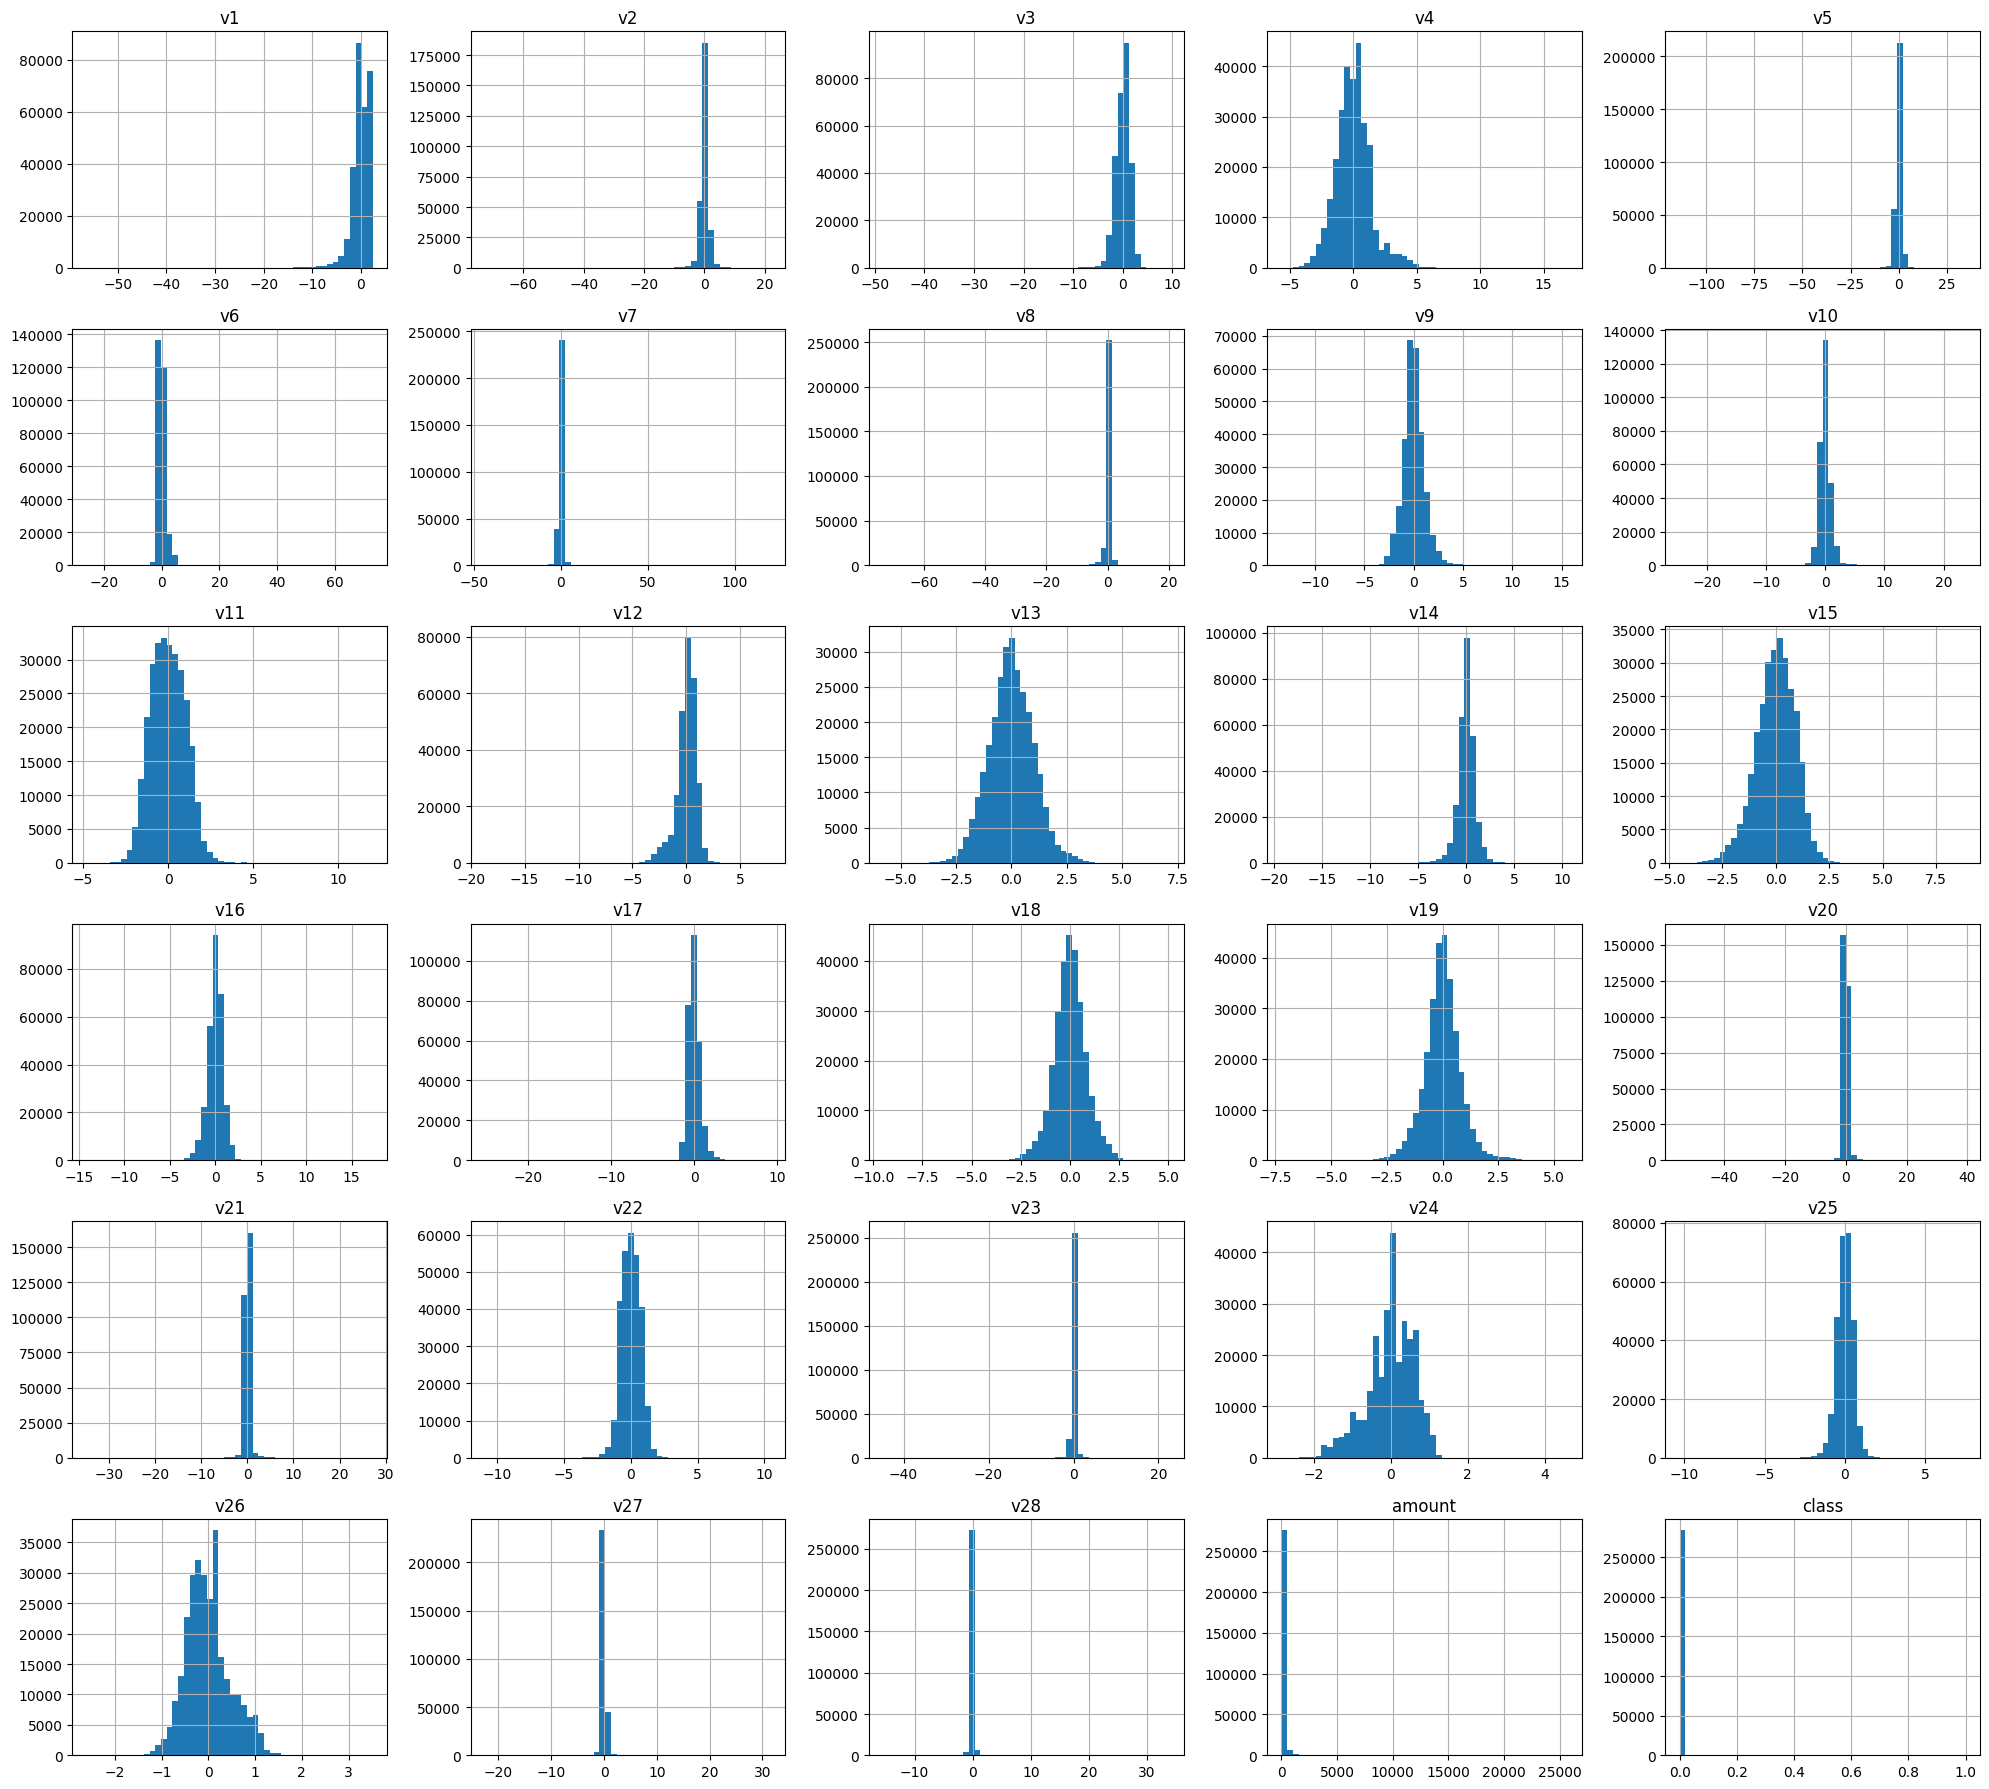

In [13]:
df.hist(figsize=(20, 18), bins=50) # [[f'v{i}' for i in range(1, 29)]]
plt.tight_layout()

plt.savefig('images/eda_distribution_per_features.png', dpi=300)
plt.show()

In [13]:
features = [f'v{i}' for i in range(1, 29)]
fig = go.Figure()

for i, col in enumerate(features):
    visible = True if i == 0 else 'legendonly'
    fig.add_trace(
        go.Histogram(
            x=df[col],
            name=col,
            visible=visible,
            # opacity=0.75,
            nbinsx=50
        )
    )

fig.update_layout(
    title="Distribution of Features (v1-v28)",
    xaxis_title="Value",
    yaxis_title="Count",
    barmode='overlay',
    margin=dict(l=20, r=20, t=50, b=20),
)
fig.show()

fig.write_html('images/eda_distribution_features.html')

In [14]:
non_feature_cols = [col for col in df.columns if col not in features]
fig = make_subplots(rows=1, cols=2, subplot_titles=non_feature_cols)

for i, col in enumerate(non_feature_cols):
    fig.add_trace(
        go.Histogram(
            x=df[col],
            name=col,
            opacity=0.75,
            nbinsx=50,
            showlegend=False
        ),
        row=1, col=i+1
    )

fig.update_layout(
    title_text="Distribution of Amount and Class Features (non-v1-v28)",
    margin=dict(l=20, r=20, t=50, b=20),
)
fig.show()

fig.write_html('images/eda_distribution_features_non_v1_v28_subplots.html')

### Feature importance

In [15]:
df_full_train, df_test = train_test_split(df, test_size=.2, random_state=SEED)
df_train, df_val = train_test_split(df_full_train, test_size=.15, random_state=SEED)

In [16]:
df_full_train.to_csv('df_full_train.csv', index=False)
df_test.to_csv('df_test.csv', index=False)

In [17]:
y_train = df_train["class"].values
y_val = df_val["class"].values
y_test = df_test["class"].values

del df_train['class']
del df_test['class']
del df_val['class']

In [18]:
print(f'Shape y_train: {y_train.shape}')
print(f'Shape y_val: {y_val.shape}')
print(f'Shape y_test: {y_test.shape}')
print(f'Shape df_train: {df_train.shape}')
print(f'Shape df_val: {df_val.shape}')
print(f'Shape df_test: {df_test.shape}')

Shape y_train: (193668,)
Shape y_val: (34177,)
Shape y_test: (56962,)
Shape df_train: (193668, 29)
Shape df_val: (34177, 29)
Shape df_test: (56962, 29)


In [19]:
tmp_model = LogisticRegression(
    penalty='l2',
    C=1.0,
    solver='liblinear',
    random_state=SEED,
    max_iter=1000,
    n_jobs=-1
)
tmp_model.fit(df_train, y_train)

/home/mmfmi/github/personal/my-credit-card-fraud-classifier/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
  warnings.warn(


LogisticRegression(max_iter=1000, n_jobs=-1, random_state=8, solver='liblinear')

In [20]:
feature_importance = pd.DataFrame({
    'feature': df_train.columns,
    'importance': tmp_model.coef_[0]
}).sort_values(by='importance', key=abs, ascending=False)

feature_importance.reset_index(drop=True, inplace=True)
feature_importance.T

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
feature,v27,v10,v14,v4,v20,v22,v9,v13,v21,v16,...,v7,v11,v26,v5,v2,v17,v18,v23,v3,amount
importance,-0.744289,-0.687493,-0.602043,0.571351,-0.458705,0.426617,-0.358342,-0.316368,0.291878,-0.226144,...,-0.09704,-0.08617,-0.062037,0.052089,0.036757,-0.023839,0.022996,0.022549,0.008728,0.00132


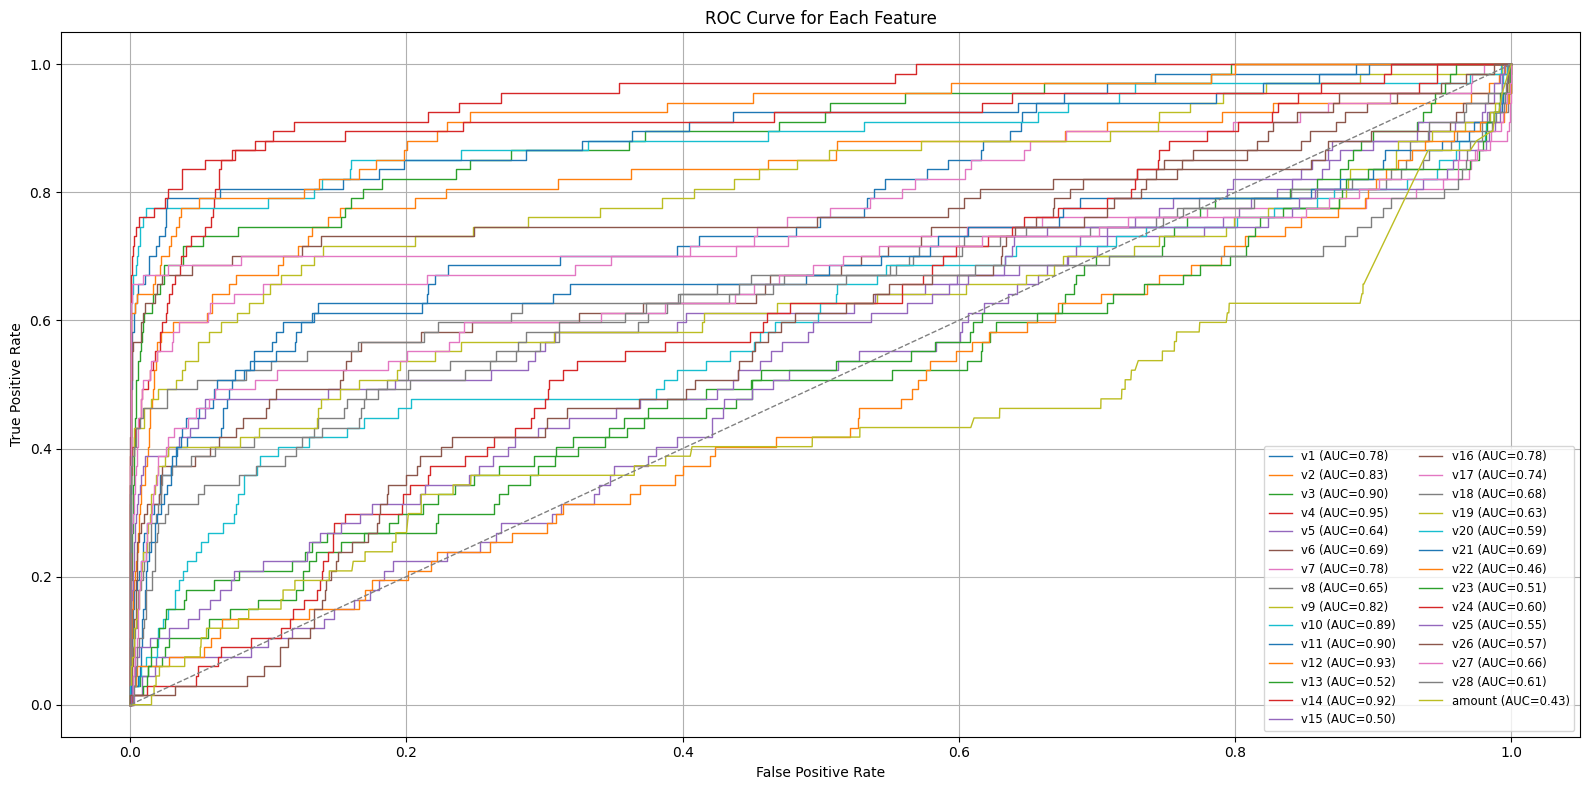

In [21]:
plt.figure(figsize=(16, 8))

for feature in df_val.columns:
    # Fit a univariate logistic regression model
    model = LogisticRegression(solver='liblinear', random_state=SEED)
    model.fit(df_train[[feature]], y_train)
    y_val_pred_proba = model.predict_proba(df_val[[feature]])[:, 1]
    fpr, tpr, _ = roc_curve(y_val, y_val_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label=f'{feature} (AUC={roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')    
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Feature')
plt.legend(fontsize='small', loc='lower right', ncol=2)
plt.grid(True)
plt.tight_layout()

plt.savefig('images/eda_roc_curve_features.png', dpi=300)
plt.show()

In [22]:
# Get predicted probabilities for each set
y_train_pred_proba = tmp_model.predict_proba(df_train)[:, 1]
y_val_pred_proba = tmp_model.predict_proba(df_val)[:, 1]
y_test_pred_proba = tmp_model.predict_proba(df_test)[:, 1]

# Compute ROC curves
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_pred_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba)

# Save results in a DataFrame
roc_df = pd.DataFrame({
    'fpr_train': pd.Series(fpr_train),
    'tpr_train': pd.Series(tpr_train),
    'fpr_val': pd.Series(fpr_val),
    'tpr_val': pd.Series(tpr_val),
    'fpr_test': pd.Series(fpr_test),
    'tpr_test': pd.Series(tpr_test),
})

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=fpr_train, y=tpr_train,
    mode='lines',
    name='Train',
    visible=True
))
fig.add_trace(go.Scatter(
    x=fpr_val, y=tpr_val,
    mode='lines',
    name='Validation',
    visible='legendonly'
))
fig.add_trace(go.Scatter(
    x=fpr_test, y=tpr_test,
    mode='lines',
    name='Test',
    visible='legendonly'
))

fig.update_layout(
    title='ROC Curve (Train, Validation, Test)',
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    legend_title='Dataset',
    width=800,
    height=500
)

fig.show()

fig.write_html('images/roc_curve_train_val_test.html')

### Correlation between features

In [24]:
df_corr = df.corr()
df_corr['class'].abs().sort_values(ascending=False)

class     1.000000
v17       0.326481
v14       0.302544
v12       0.260593
v10       0.216883
v16       0.196539
v3        0.192961
v7        0.187257
v11       0.154876
v4        0.133447
v18       0.111485
v1        0.101347
v9        0.097733
v5        0.094974
v2        0.091289
v6        0.043643
v21       0.040413
v19       0.034783
v20       0.020090
v8        0.019875
v27       0.017580
v28       0.009536
v24       0.007221
amount    0.005632
v13       0.004570
v26       0.004455
v15       0.004223
v25       0.003308
v23       0.002685
v22       0.000805
Name: class, dtype: float64

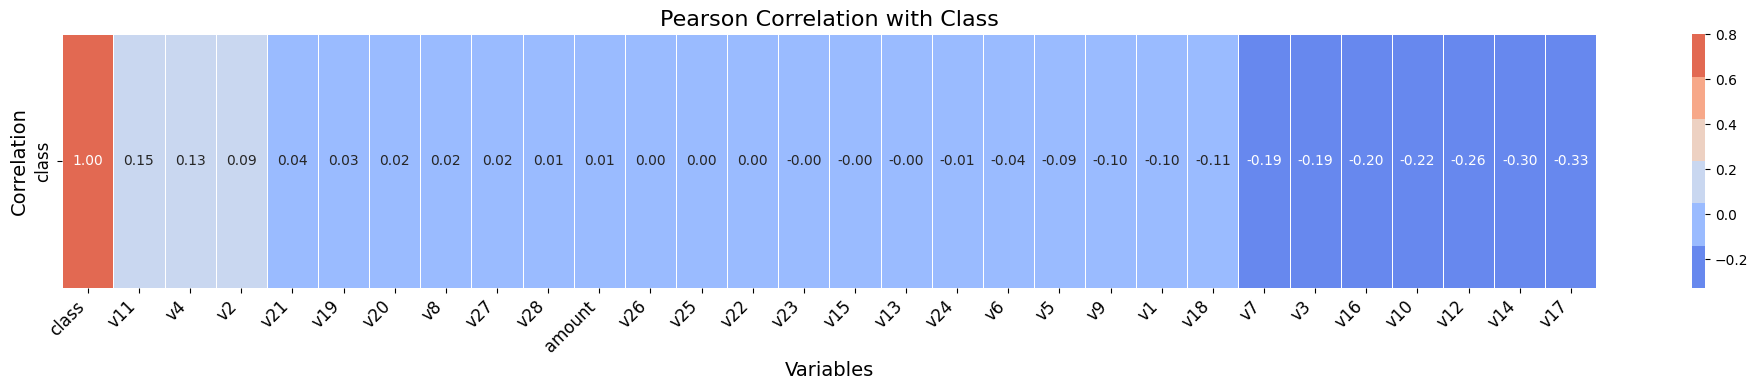

In [25]:
f, ax = plt.subplots(figsize=(20,4))

my_plot = sns.heatmap(
    # corr_train,
    df_corr.filter(items=['class']).sort_values(by='class', ascending=False).T,
    cmap=sns.color_palette("coolwarm"),
    linewidths=0.5,
    annot=True,
    vmax=0.8,
    fmt=".2f",
    # square=True
)

my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45)

#modify individual font size of elements
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('Variables', fontsize=14)
plt.ylabel('Correlation', fontsize=14)
plt.title('Pearson Correlation with Class', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.savefig('./images/eda_pearson_correlation_heatmap.png', dpi=300)
plt.show()

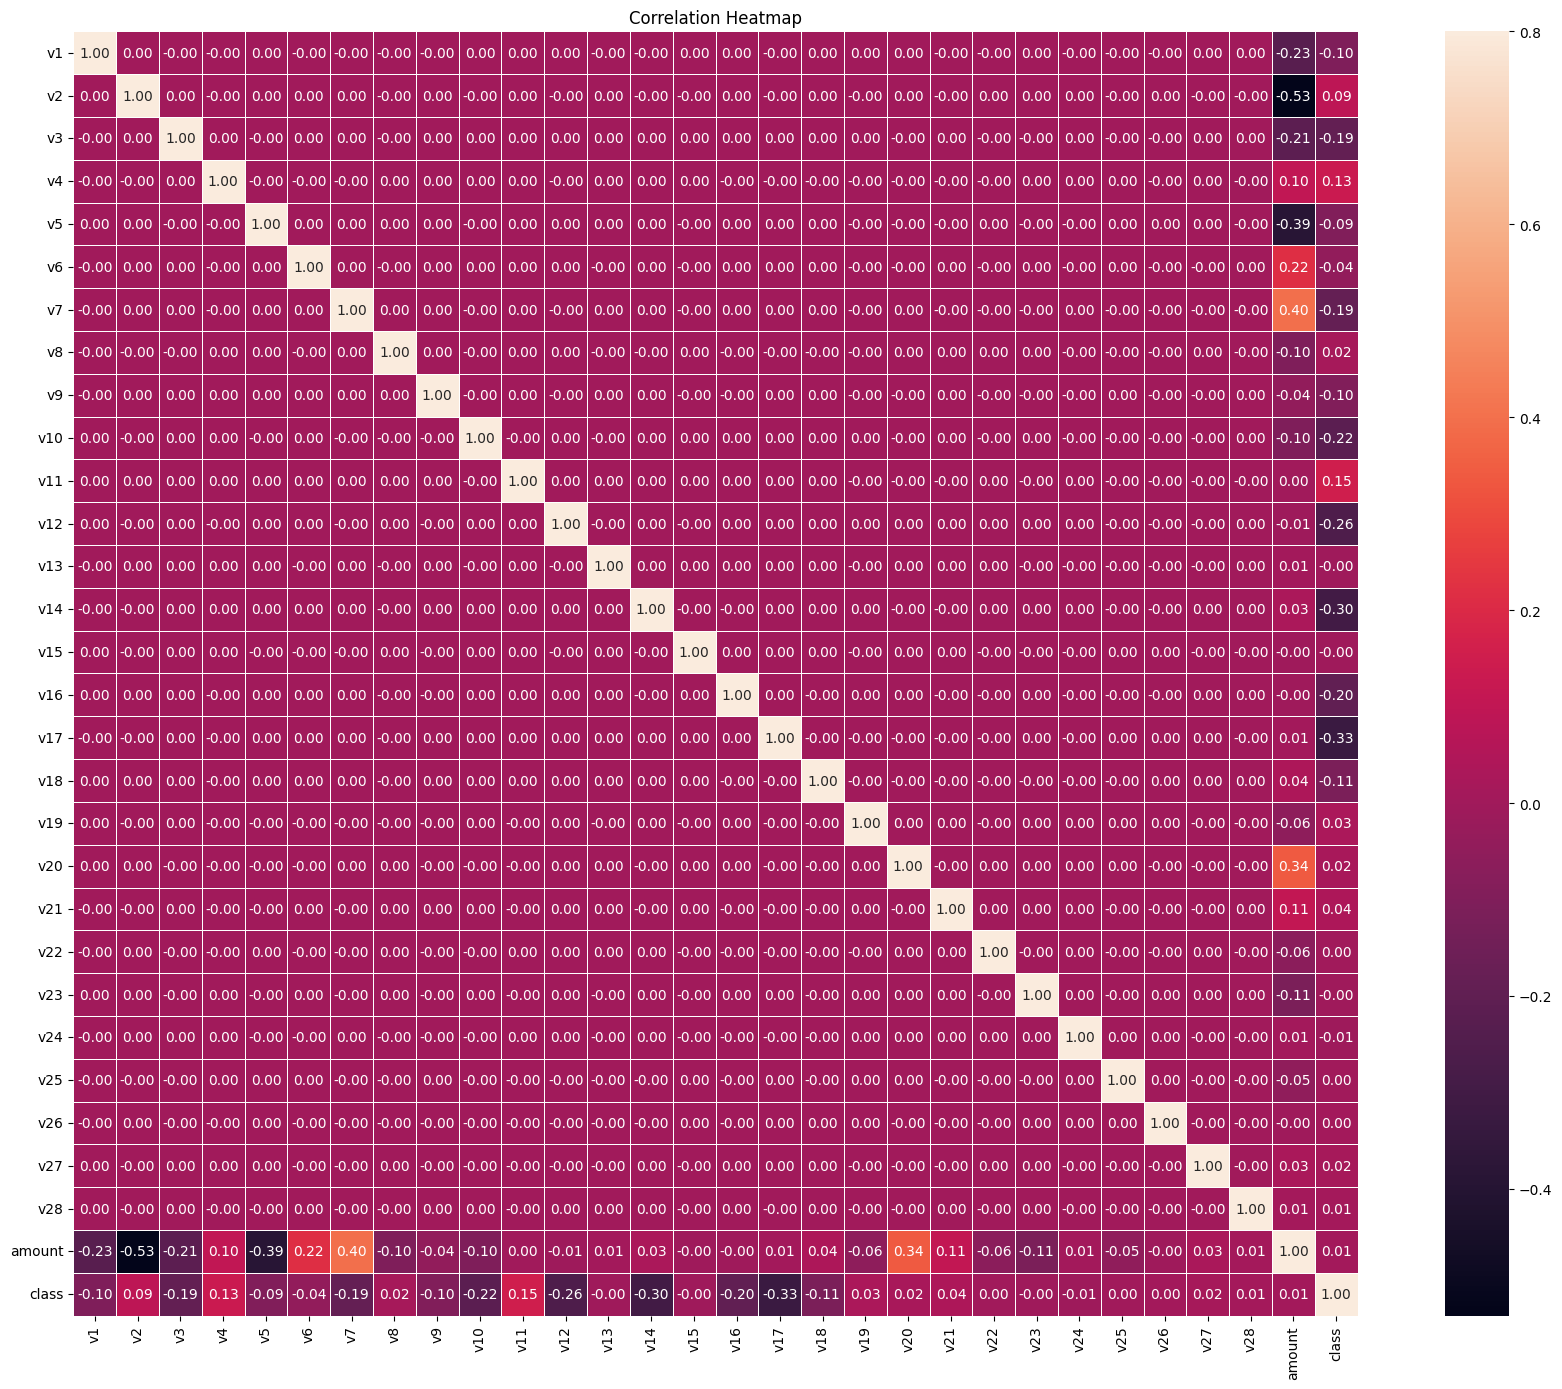

In [26]:
plt.figure(figsize=(18, 14))
sns.heatmap(df_corr, annot=True, vmax=0.8, fmt=".2f", linewidths=.5, square=True)
plt.title('Correlation Heatmap')
plt.tight_layout()

plt.savefig('images/eda_complete_pearson_correlation_heatmap.png', dpi=300)
plt.show()